In [1]:
import re
import pandas as pd
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

from pathlib import Path
import torch



d:\CODE\Deep_ml_project\AI-financial-sentiment-prediction\venv\Lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:


def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)      
    text = re.sub(r"@\w+", "", text)        
    text = re.sub(r"^user:\s*", "", text, flags=re.IGNORECASE)  
    text = re.sub(r"^user\s*", "", text, flags=re.IGNORECASE)  
    text = re.sub(r"[\"]+", "", text)        
    text = re.sub(r"\s+", " ", text).strip() 
    return text



In [ ]:
def lables_zero_one(y: int) -> int:
    return 1 if int(y) == 1 else 0

In [4]:
df = pd.read_csv("data/stock_data.csv")
df["Text"] = df["Text"].astype(str).apply(clean_text)
print(df.head)

<bound method NDFrame.head of                                                    Text  Sentiment
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1
1     AAP MOVIE. 55% return for the FEA/GEED indicat...          1
2     I'd be afraid to short AMZN - they are looking...          1
3                                       MNTA Over 12.00          1
4                                         OI Over 21.37          1
...                                                 ...        ...
5786  Industry body CII said #discoms are likely to ...         -1
5787  #Gold prices slip below Rs 46,000 as #investor...         -1
5788  Workers at Bajaj Auto have agreed to a 10% wag...          1
5789  #Sharemarket LIVE: Sensex off day’s high, up 6...          1
5790  #Sensex, #Nifty climb off day's highs, still u...          1

[5791 rows x 2 columns]>


In [ ]:
# training config
WARMUP_EPOCHS = 3  # Train head 
FINETUNE_EPOCHS = 5  # fine tune full model 
PATIENCE = 3  #early stopping


In [ ]:
class FinancialSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len: int = 128):

        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True, # cut off long texts
            padding='max_length', # pad 
            max_length=self.max_len,
            return_tensors='pt' #pytorch output
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            "label": torch.tensor(label, dtype=torch.long)
        }

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

train_dataset = FinancialSentimentDataset(
    texts=df["Text"].values,
    labels=df["Sentiment"].values,
    tokenizer=tokenizer
)


In [ ]:
from sklearn.model_selection import train_test_split

labels_binary = df["Sentiment"].apply(lables_zero_one).values

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Text"].values, labels_binary, test_size=0.2, random_state=67)

In [ ]:
print(f"Training dataset: {len(train_texts)} samples")
print(f"Validation dataset: {len(val_texts)} samples")

positive_count = sum(train_labels)
negative_count = len(train_labels) - positive_count

print(f"\nClass distribution:")
print(f"  Positive: {positive_count} ({positive_count/len(train_labels):.1%})")
print(f"  Negative: {negative_count} ({negative_count/len(train_labels):.1%})")
print(f"  Imbalance ratio: {positive_count/negative_count:.2f}:1")

pos_weight = torch.tensor(negative_count / positive_count, dtype=torch.float)


Training dataset: 4632 samples
Validation dataset: 1159 samples

Class distribution:
  Positive: 2974 (64.2%)
  Negative: 1658 (35.8%)
  Imbalance ratio: 1.79:1


In [ ]:
# Create datasets with original data
train_dataset = FinancialSentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = FinancialSentimentDataset(val_texts, val_labels, tokenizer)



In [ ]:
import torch.nn as nn
from transformers import AutoModel

class FinbertBackbone(nn.Module):
    def __init__(self, modelName: str = "ProsusAI/finbert"):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(modelName)
        self.hiddenSize = self.encoder.config.hidden_size  # 768

    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        cls = out.last_hidden_state[:, 0]  # [CLS]
        return cls  # [batch, hidden]
    

class BinaryHead(nn.Module):
    def __init__(self, inFeatures: int, pDrop: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(pDrop)
        self.fc = nn.Linear(inFeatures, 1)  # single logit

    def forward(self, x):
        x = self.dropout(x)
        logits = self.fc(x).squeeze(-1)    # [batch]
        return logits


class FinbertBinaryClf(nn.Module):
    def __init__(self, modelName: str = "ProsusAI/finbert", pDrop: float = 0.1):
        super().__init__()
        self.backbone = FinbertBackbone(modelName)
        self.head = BinaryHead(self.backbone.hiddenSize, pDrop)

    def forward(self, input_ids, attention_mask):
        feats = self.backbone(input_ids, attention_mask)
        logits = self.head(feats)
        return logits


In [ ]:
from torch.utils.data import DataLoader, random_split
from torch.optim import AdamW
import torch.nn.functional as F
import torch
from transformers import AutoTokenizer
from sklearn.metrics import f1_score, accuracy_score

def getLoaders(texts,labels, tokenizer, maxLen=128, batchSize=64, valFrac=0.2, seed=67):
    ds = FinancialSentimentDataset(texts,labels, tokenizer, max_len=maxLen)
    valLen = int(len(ds) * valFrac)
    trainLen = len(ds) - valLen
    gen = torch.Generator().manual_seed(seed)
    trainDs, valDs = random_split(ds, [trainLen, valLen], generator=gen)
    return (
        DataLoader(trainDs, batch_size=batchSize, shuffle=True),
        DataLoader(valDs, batch_size=batchSize, shuffle=False),
    )

def step(model, batch, device, posWeight=None, train=True, optimizer=None, clip=1.0):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["label"].float().to(device)    # 0/1 BCE

    logits = model(input_ids, attention_mask)
    if posWeight is None:
        loss = F.binary_cross_entropy_with_logits(logits, labels)
    else:
        bce = nn.BCEWithLogitsLoss(pos_weight=posWeight.to(device))
        loss = bce(logits, labels)

    if train:
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    probs = torch.sigmoid(logits).detach().cpu().numpy()
    preds = (probs >= 0.5).astype(int)
    y_true = labels.detach().cpu().numpy().astype(int)
    return loss.item(), preds, y_true

def runEpoch(model, loader, device, train, optimizer=None, posWeight=None):
    model.train(train)
    losses, allPreds, allTrue = [], [], []
    for batch in loader:
        loss, preds, y_true = step(model, batch, device, posWeight, train, optimizer)
        losses.append(loss)
        allPreds.extend(preds.tolist())
        allTrue.extend(y_true.tolist())
    acc = accuracy_score(allTrue, allPreds)
    f1 = f1_score(allTrue, allPreds)
    return float(sum(losses)/max(1,len(losses))), acc, f1


In [ ]:
from transformers import AutoTokenizer

# ORIGINAL WORKING CONFIGURATION (matching the good results)
modelName = "ProsusAI/finbert"
MAX_LEN = 128
BATCH_SIZE = 64 
DROPOUT = 0.1 
WEIGHT_DECAY = 0.01

# Phase 1: Warmup (frozen backbone)
WARMUP_EPOCHS = 1 
WARMUP_LR = 2e-4

# Phase 2: Fine-tuning (unfrozen backbone)
FINETUNE_EPOCHS = 1  # Just 1 epoch (we know epoch 1 is best from experiments)
FINETUNE_LR = 2e-5  # 10x lower
PATIENCE = 3  # Early stopping (won't trigger with 1 epoch)

tokenizer = AutoTokenizer.from_pretrained(modelName)

trainLoader, valLoader = getLoaders(train_texts, train_labels, tokenizer, 
                                     maxLen=MAX_LEN, batchSize=BATCH_SIZE)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"{'='*80}")
print(f"TWO-PHASE TRAINING (Original Working Config)")
print(f"{'='*80}")
print(f"Device: {device}")
print(f"Training samples: {len(train_texts):,}")
print(f"Validation samples: {len(val_texts):,}")
print(f"Batches per epoch: {len(trainLoader)}")
print(f"\nPhase 1 (Warmup): {WARMUP_EPOCHS} epoch, LR={WARMUP_LR}, Batch={BATCH_SIZE}")
print(f"Phase 2 (Fine-tune): Up to {FINETUNE_EPOCHS} epochs, LR={FINETUNE_LR}")
print(f"Dropout: {DROPOUT} (original)")
print(f"Early stopping patience: {PATIENCE}")
print(f"{'='*80}\n")

# Initialize model with ORIGINAL dropout
model = FinbertBinaryClf(modelName, pDrop=DROPOUT).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters: {total_params:,}\n")

TWO-PHASE TRAINING (Original Working Config)
Device: cuda
Training samples: 4,632
Validation samples: 1,159
Batches per epoch: 58

Phase 1 (Warmup): 1 epoch, LR=0.0002, Batch=64
Phase 2 (Fine-tune): Up to 1 epochs, LR=2e-05
Dropout: 0.1 (original)
Early stopping patience: 3

Total model parameters: 109,483,009



In [ ]:

for p in model.backbone.parameters():
    p.requires_grad = False

trainable_warmup = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("="*80)
print("PHASE 1: HEAD WARMUP (Backbone Frozen)")
print("="*80)
print(f"Trainable parameters: {trainable_warmup:,}")
print(f"Data-to-parameter ratio: {len(train_texts) / trainable_warmup:.2f}:1")
print(f"\nTraining head for {WARMUP_EPOCHS} epochs with class weights...\n")

# Optimizer for warmup
optimizer_warmup = AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=WARMUP_LR,
    weight_decay=WEIGHT_DECAY
)

# Warmup training
warmup_history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

for epoch in range(WARMUP_EPOCHS):
    trLoss, trAcc, trF1 = runEpoch(model, trainLoader, device, train=True,
                                    optimizer=optimizer_warmup, posWeight=pos_weight)
    vaLoss, vaAcc, vaF1 = runEpoch(model, valLoader, device, train=False)
    
    warmup_history['train_loss'].append(trLoss)
    warmup_history['train_acc'].append(trAcc)
    warmup_history['train_f1'].append(trF1)
    warmup_history['val_loss'].append(vaLoss)
    warmup_history['val_acc'].append(vaAcc)
    warmup_history['val_f1'].append(vaF1)
    
    print(f"[Warmup] Epoch {epoch+1}/{WARMUP_EPOCHS}:")
    print(f"  Train - Loss: {trLoss:.4f}, Acc: {trAcc:.3f}, F1: {trF1:.3f}")
    print(f"  Val   - Loss: {vaLoss:.4f}, Acc: {vaAcc:.3f}, F1: {vaF1:.3f}")
    print()

print("Warmup phase complete!\n")


for p in model.backbone.parameters():
    p.requires_grad = True

trainable_finetune = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("="*80)
print("PHASE 2: FINE-TUNING (Backbone Unfrozen + Early Stopping)")
print("="*80)
print(f"Trainable parameters: {trainable_finetune:,}")
print(f"Data-to-parameter ratio: {len(train_texts) / trainable_finetune:.6f}:1")
print(f"Learning rate: {FINETUNE_LR} (10x lower than warmup)")
print(f"Early stopping patience: {PATIENCE} epochs")
print(f"\nFine-tuning for up to {FINETUNE_EPOCHS} epochs...\n")

# (LOWER LR!)
optimizer_finetune = AdamW(
    model.parameters(),
    lr=FINETUNE_LR,
    weight_decay=WEIGHT_DECAY
)

best_val_loss = float('inf')
best_val_f1 = 0.0
patience_counter = 0
best_epoch = 0

finetune_history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

for epoch in range(FINETUNE_EPOCHS):
    trLoss, trAcc, trF1 = runEpoch(model, trainLoader, device, train=True,
                                    optimizer=optimizer_finetune, posWeight=pos_weight)
    vaLoss, vaAcc, vaF1 = runEpoch(model, valLoader, device, train=False)
    
    finetune_history['train_loss'].append(trLoss)
    finetune_history['train_acc'].append(trAcc)
    finetune_history['train_f1'].append(trF1)
    finetune_history['val_loss'].append(vaLoss)
    finetune_history['val_acc'].append(vaAcc)
    finetune_history['val_f1'].append(vaF1)
    
    print(f"[Fine-tune] Epoch {epoch+1}/{FINETUNE_EPOCHS}:")
    print(f"  Train - Loss: {trLoss:.4f}, Acc: {trAcc:.3f}, F1: {trF1:.3f}")
    print(f"  Val   - Loss: {vaLoss:.4f}, Acc: {vaAcc:.3f}, F1: {vaF1:.3f}")
    
    if vaLoss < best_val_loss:
        best_val_loss = vaLoss
        best_val_f1 = vaF1
        best_epoch = epoch
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': len(warmup_history['train_loss']) + epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer_finetune.state_dict(),
            'val_loss': vaLoss,
            'val_f1': vaF1,
        }, "finbert_finetuned.pt")
        print(f"  ✓ New best model saved! (Val Loss: {vaLoss:.4f}, Val F1: {vaF1:.3f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")
    
    print()
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"⚠ Early stopping triggered at fine-tune epoch {epoch+1}")
        print(f"Best model from fine-tune epoch {best_epoch+1}")
        print(f"Best validation loss: {best_val_loss:.4f}")
        print(f"Best validation F1: {best_val_f1:.3f}")
        break

print("\n" + "="*80)
print("✓ Training complete!")
print(f"Best model saved to: finbert_finetuned.pt")
print("="*80)


PHASE 1: HEAD WARMUP (Backbone Frozen)
Trainable parameters: 769
Data-to-parameter ratio: 6.02:1

Training head for 1 epochs with class weights...

[Warmup] Epoch 1/1:
  Train - Loss: 0.6452, Acc: 0.624, F1: 0.720
  Val   - Loss: 0.5674, Acc: 0.727, F1: 0.818

✓ Warmup phase complete!

PHASE 2: FINE-TUNING (Backbone Unfrozen + Early Stopping)
Trainable parameters: 109,483,009
Data-to-parameter ratio: 0.000042:1
Learning rate: 2e-05 (10x lower than warmup)
Early stopping patience: 3 epochs

Fine-tuning for up to 1 epochs...

[Fine-tune] Epoch 1/1:
  Train - Loss: 0.5001, Acc: 0.763, F1: 0.825
  Val   - Loss: 0.4809, Acc: 0.788, F1: 0.848
  ✓ New best model saved! (Val Loss: 0.4809, Val F1: 0.848)


✓ Training complete!
Best model saved to: finbert_finetuned.pt


In [16]:
# Create training summary visualization
print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)

# Combine all training history
all_epochs = ['W1'] + [f'F{i+1}' for i in range(len(finetune_history['train_loss']))]
all_train_loss = warmup_history['train_loss'] + finetune_history['train_loss']
all_val_loss = warmup_history['val_loss'] + finetune_history['val_loss']
all_train_f1 = warmup_history['train_f1'] + finetune_history['train_f1']
all_val_f1 = warmup_history['val_f1'] + finetune_history['val_f1']

print("\nEpoch-by-Epoch Progress:")
print(f"{'Epoch':<8} {'Train Loss':<12} {'Val Loss':<12} {'Train F1':<10} {'Val F1':<10}")
print("-" * 60)

for i, epoch_name in enumerate(all_epochs):
    print(f"{epoch_name:<8} {all_train_loss[i]:<12.4f} {all_val_loss[i]:<12.4f} "
          f"{all_train_f1[i]:<10.3f} {all_val_f1[i]:<10.3f}")

print("\nBest Performance:")
best_idx = all_val_loss.index(min(all_val_loss))
print(f"  Epoch: {all_epochs[best_idx]}")
print(f"  Val F1: {all_val_f1[best_idx]:.3f}")
print(f"  Val Loss: {all_val_loss[best_idx]:.4f}")
print("="*80)



TRAINING SUMMARY

Epoch-by-Epoch Progress:
Epoch    Train Loss   Val Loss     Train F1   Val F1    
------------------------------------------------------------
W1       0.6452       0.5674       0.720      0.818     
F1       0.5001       0.4809       0.825      0.848     

Best Performance:
  Epoch: F1
  Val F1: 0.848
  Val Loss: 0.4809


In [ ]:
print("\n" + "="*80)
print("BATCH-LEVEL VISUALIZATION (rerunning Fine-tune Epoch 1)")
print("="*80)
print("Tracking metrics every 5 batches to visualize training progress...\n")

checkpoint = torch.load("finbert_finetuned.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

for p in model.backbone.parameters():
    p.requires_grad = True

optimizer_viz = AdamW(model.parameters(), lr=FINETUNE_LR, weight_decay=WEIGHT_DECAY)
batch_metrics = {'batch': [], 'loss': [], 'acc': [], 'f1': []}
model.train()

all_losses, all_preds, all_true = [], [], []

print(f"Processing {len(trainLoader)} batches...")
for batch_idx, batch in enumerate(trainLoader):
    # Run batch
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["label"].float().to(device)

    logits = model(input_ids, attention_mask)
    bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
    loss = bce(logits, labels)

    optimizer_viz.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer_viz.step()

    probs = torch.sigmoid(logits).detach().cpu().numpy()
    preds = (probs >= 0.5).astype(int)
    y_true = labels.detach().cpu().numpy().astype(int)

    all_losses.append(loss.item())
    all_preds.extend(preds.tolist())
    all_true.extend(y_true.tolist())

    # Save metrics every 5 batches
    if batch_idx % 5 == 0 or batch_idx == len(trainLoader) - 1:
        current_loss = sum(all_losses) / len(all_losses)
        current_acc = accuracy_score(all_true, all_preds)
        current_f1 = f1_score(all_true, all_preds)
        
        batch_metrics['batch'].append(batch_idx)
        batch_metrics['loss'].append(current_loss)
        batch_metrics['acc'].append(current_acc)
        batch_metrics['f1'].append(current_f1)
        
        if batch_idx % 20 == 0:
            print(f"  Batch {batch_idx:3d}/{len(trainLoader)} - "
                  f"Loss: {current_loss:.4f}, Acc: {current_acc:.3f}, F1: {current_f1:.3f}")

final_loss = sum(all_losses) / len(all_losses)
final_acc = accuracy_score(all_true, all_preds)
final_f1 = f1_score(all_true, all_preds)

print(f"\nFinal metrics: Loss={final_loss:.4f}, Acc={final_acc:.3f}, F1={final_f1:.3f}")
print("✓ Batch tracking complete!\n")



BATCH-LEVEL VISUALIZATION (Re-running Fine-tune Epoch 1)
Tracking metrics every 5 batches to visualize training progress...

Processing 58 batches...
  Batch   0/58 - Loss: 0.3430, Acc: 0.844, F1: 0.891


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

#loss plot
axes[0].plot(batch_metrics['batch'], batch_metrics['loss'], marker='o', linewidth=2, markersize=4)
axes[0].set_xlabel('Batch Number', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].set_title('Loss During Fine-Tuning (Batch Level)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(bottom=0)

# acc plot
axes[1].plot(batch_metrics['batch'], batch_metrics['acc'], marker='s', linewidth=2, markersize=4, color='green')
axes[1].set_xlabel('Batch Number', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Accuracy During Fine-Tuning (Batch Level)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

# F1 plot
axes[2].plot(batch_metrics['batch'], batch_metrics['f1'], marker='^', linewidth=2, markersize=4, color='red')
axes[2].set_xlabel('Batch Number', fontsize=11)
axes[2].set_ylabel('F1 Score', fontsize=11)
axes[2].set_title('F1 Score During Fine-Tuning (Batch Level)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('finbert_batch_level_training.png', dpi=150, bbox_inches='tight')
plt.show()



In [ ]:
fig = plt.figure(figsize=(16, 10))

# Create 2x3 grid
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# (warmup + Finetune)
all_epochs_full = ['W1'] + [f'F{i+1}' for i in range(len(finetune_history['train_loss']))]
all_train_loss = warmup_history['train_loss'] + finetune_history['train_loss']
all_val_loss = warmup_history['val_loss'] + finetune_history['val_loss']
all_train_f1 = warmup_history['train_f1'] + finetune_history['train_f1']
all_val_f1 = warmup_history['val_f1'] + finetune_history['val_f1']

# Loss 
ax1 = fig.add_subplot(gs[0, 0])
x_pos = list(range(len(all_epochs_full)))
ax1.plot(x_pos, all_train_loss, 'o-', label='Train', linewidth=2, markersize=8)
ax1.plot(x_pos, all_val_loss, 's-', label='Validation', linewidth=2, markersize=8)
ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Fine-tune starts')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(all_epochs_full)
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax1.set_title('Loss: Epoch-Level (Warmup + Fine-tune)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

#acc 
ax2 = fig.add_subplot(gs[0, 1])
all_train_acc = warmup_history['train_acc'] + finetune_history['train_acc']
all_val_acc = warmup_history['val_acc'] + finetune_history['val_acc']
ax2.plot(x_pos, all_train_acc, 'o-', label='Train', linewidth=2, markersize=8, color='green')
ax2.plot(x_pos, all_val_acc, 's-', label='Validation', linewidth=2, markersize=8, color='darkgreen')
ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(all_epochs_full)
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Accuracy: Epoch-Level', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# F1
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(x_pos, all_train_f1, 'o-', label='Train', linewidth=2, markersize=8, color='red')
ax3.plot(x_pos, all_val_f1, 's-', label='Validation', linewidth=2, markersize=8, color='darkred')
ax3.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(all_epochs_full)
ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax3.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
ax3.set_title('F1 Score: Epoch-Level', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)


ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(batch_metrics['batch'], batch_metrics['loss'], 'o-', linewidth=2, markersize=3, color='blue')
ax4.set_xlabel('Batch Number', fontsize=11, fontweight='bold')
ax4.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax4.set_title('Loss: Batch-Level (Fine-tune Epoch 1)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(batch_metrics['batch'], batch_metrics['acc'], 's-', linewidth=2, markersize=3, color='green')
ax5.set_xlabel('Batch Number', fontsize=11, fontweight='bold')
ax5.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax5.set_title('Accuracy: Batch-Level (Fine-tune Epoch 1)', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(batch_metrics['batch'], batch_metrics['f1'], '^-', linewidth=2, markersize=3, color='red')
ax6.set_xlabel('Batch Number', fontsize=11, fontweight='bold')
ax6.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
ax6.set_title('F1 Score: Batch-Level (Fine-tune Epoch 1)', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

fig.suptitle('FinBERT Training Progress: Epoch & Batch Level Analysis', 
             fontsize=14, fontweight='bold', y=0.995)

plt.savefig('finbert_complete_training_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Complete training analysis saved to: finbert_complete_training_analysis.png")


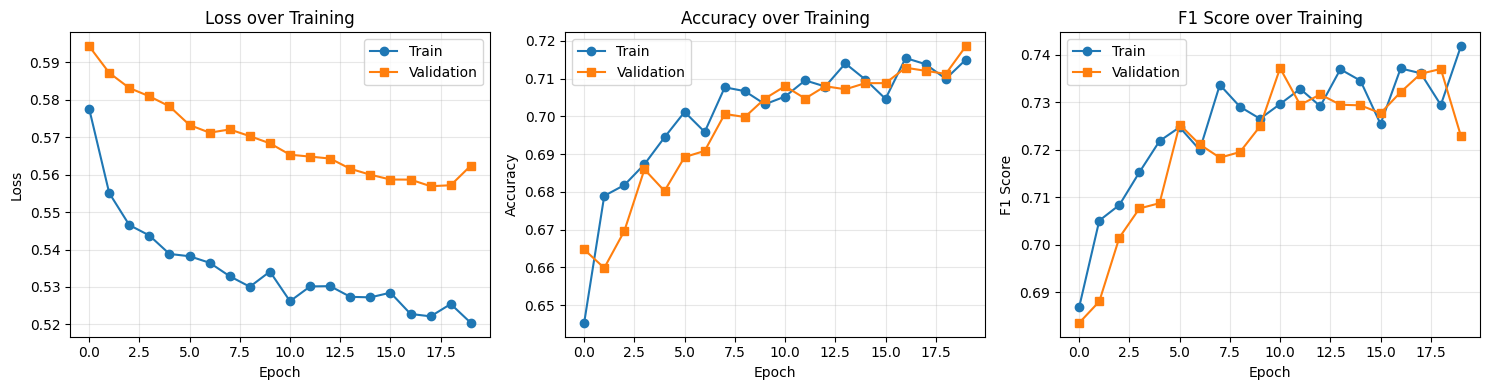

Training curves saved to: finbert_training_history.png


In [ ]:
import matplotlib.pyplot as plt

full_history = {
    'train_loss': warmup_history['train_loss'] + finetune_history['train_loss'],
    'train_acc': warmup_history['train_acc'] + finetune_history['train_acc'],
    'train_f1': warmup_history['train_f1'] + finetune_history['train_f1'],
    'val_loss': warmup_history['val_loss'] + finetune_history['val_loss'],
    'val_acc': warmup_history['val_acc'] + finetune_history['val_acc'],
    'val_f1': warmup_history['val_f1'] + finetune_history['val_f1']
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

warmup_end = len(warmup_history['train_loss']) - 0.5

# Loss 
axes[0].plot(full_history['train_loss'], label='Train', marker='o')
axes[0].plot(full_history['val_loss'], label='Validation', marker='s')
axes[0].axvline(x=warmup_end, color='red', linestyle='--', alpha=0.7, label='Fine-tune starts')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss over Training (Warmup + Fine-tune)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# acc
axes[1].plot(full_history['train_acc'], label='Train', marker='o')
axes[1].plot(full_history['val_acc'], label='Validation', marker='s')
axes[1].axvline(x=warmup_end, color='red', linestyle='--', alpha=0.7, label='Fine-tune starts')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy over Training (Warmup + Fine-tune)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1 plot
axes[2].plot(full_history['train_f1'], label='Train', marker='o')
axes[2].plot(full_history['val_f1'], label='Validation', marker='s')
axes[2].axvline(x=warmup_end, color='red', linestyle='--', alpha=0.7, label='Fine-tune starts')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score over Training (Warmup + Fine-tune)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('finbert_finetuned_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved to: finbert_finetuned_history.png")


In [ ]:
# Load best checkpoint
checkpoint = torch.load("finbert_finetuned.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()



In [ ]:
@torch.no_grad()
def predictTexts(texts, tokenizer, model, maxLen=128, threshold=0.5, device=None):

    device = device or next(model.parameters()).device
    model.eval()
    
    if isinstance(texts, str):
        texts = [texts]
    
    texts = [clean_text(t) for t in texts]
    
    enc = tokenizer(
        texts, truncation=True, padding="max_length", max_length=maxLen, return_tensors="pt"
    )
    logits = model(enc["input_ids"].to(device), enc["attention_mask"].to(device))
    probs = torch.sigmoid(logits).cpu().numpy()
    labels = (probs >= threshold).astype(int)  # 1=positive, 0=negative
    return labels, probs


In [ ]:
# Test predictions
test_texts = [
    "Stock prices are soaring! Great quarterly earnings reported.",
    "Company faces bankruptcy, stocks plummet.",
    "Market remains stable with moderate growth.",
    "$AAPL breaking new records today! 🚀",
    "Massive losses reported in Q3, investors worried."
]

labels, probs = predictTexts(test_texts, tokenizer, model, device=device)

print("\nTest Predictions:\n" + "="*80)
for text, label, prob in zip(test_texts, labels, probs):
    sentiment = "POSITIVE" if label == 1 else "NEGATIVE"
    confidence = prob if label == 1 else 1 - prob
    print(f"Text: {text}")
    print(f"Sentiment: {sentiment} (confidence: {confidence:.3f})")
    print()



Test Predictions:
Text: Stock prices are soaring! Great quarterly earnings reported.
Sentiment: POSITIVE (confidence: 0.884)

Text: Company faces bankruptcy, stocks plummet.
Sentiment: NEGATIVE (confidence: 0.931)

Text: Market remains stable with moderate growth.
Sentiment: POSITIVE (confidence: 0.931)

Text: $AAPL breaking new records today! 🚀
Sentiment: POSITIVE (confidence: 0.942)

Text: Massive losses reported in Q3, investors worried.
Sentiment: NEGATIVE (confidence: 0.899)

